### This notebook evaluates a grid run of multiple models using pre-defined metrics 

In [511]:
import numpy as np
import pandas as pd
import os
import scipy.stats 
import h5py
import loss
from tensorflow.python.keras import backend as K
from modelzoo import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go

In [512]:
def np_mse(a, b):
    return ((a - b)**2).mean(axis=0).mean(axis=0)

def scipy_pr(y_true, y_pred):
    _,_,T = y_true.shape
    res_pr = np.zeros(T)
    for t in range(T):
        pr = scipy.stats.pearsonr(y_true[:,:,t].flatten(), y_pred[:,:,t].flatten())[0]
        res_pr[t] = pr
    return res_pr

def np_poiss(y_true, y_pred):
    return np.nanmean(np.nanmean(y_pred - y_true * np.log(y_pred), axis=0), axis=0)

# def loop_pois(y_true, y_pred):
#     _,_,T = y_true.shape
#     res_pr = np.zeros(T)
#     for t in range(T):
#         pr = np_poiss(y_true[:,:,t].flatten(), y_pred[:,:,t].flatten())
#         res_pr[t] = np.nanmean(pr) 
# #         print(pr)
# #         break
#     return res_pr

def get_metrics(y_true, y_pred):
    mse = np_mse(test_y, test_pred)
    pr = scipy_pr(test_y, test_pred)
    pois = np_poiss(test_y, test_pred)
    return ({'mse': mse,
            'pr': pr,
             'pois': pois})

In [513]:
#custom_train.fit_robust("basenjimod", "poisson", 2048, 128, "/home/shush/profile/QuantPred/datasets/ATAC_v3/i_3072_w_1", num_epochs=20, output_dir="/home/shush/profile/QuantPred/compare_training/2v3_custom/")
#custom_train.fit_robust("basenjimod", "poisson", 2048, 128, "/home/shush/profile/QuantPred/datasets/ATAC_v2/i_3072_w_1", num_epochs=20, output_dir="/home/shush/profile/QuantPred/compare_training/1v2_custom/")
grid_dir = 'compare_training/'

In [514]:
preds = [os.path.join(grid_dir, subdir, 'pred.h5') for subdir in os.listdir(grid_dir) if os.path.isdir(os.path.join(grid_dir, subdir))]

In [544]:
preds = []
preds_bpnet = []
for subdir in os.listdir(grid_dir):
    sub_path = os.path.join(grid_dir, subdir)
    if os.path.isdir(sub_path):
        for f in os.listdir(sub_path):
            if 'pred' in f:
                preds.append(os.path.join(sub_path,f))

In [545]:
preds


['compare_training/3v2_old_bpnet/pred_i_2048_w_1_bpnet_multinomialnll.h5',
 'compare_training/2v3_custom_bpnet/pred.h5',
 'compare_training/1v2_custom/pred.h5',
 'compare_training/3v2_old/pred_i_2048_w_128_basenjimod_poisson.h5',
 'compare_training/2v3_custom/pred.h5',
 'compare_training/1v2_custom_bpnet/pred.h5']

In [546]:
eval_metrics = {}
for pred in preds:
    dataset = h5py.File(pred, 'r')
    test_pred = dataset['test_pred'][:]
    test_y = dataset['test_y'][:]
    avg_metrics = {k:v.mean() for k,v in get_metrics(test_y, test_pred).items()}
    eval_metrics[pred] = avg_metrics

/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

divide by zero encountered in log

/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning:

invalid value encountered in log



In [532]:
# pr_v2 = eval_metrics['compare_training/1v2_custom/pred.h5']['pr']
# plt.scatter(range(len(pr_v2)), pr_v2)
# pr_v3 = eval_metrics['compare_training/2v3_custom/pred.h5']['pr']
# plt.scatter(range(len(pr_v3)), pr_v3, color='r')

In [549]:
col_dict = {'1v2_custom': 'basenji_custom_fit_peak_centered', 
             '2v3_custom': 'basenji_custom_fit_random_chop', 
             '3v2_old': 'basenji_old_fit_peak_centered',
           '1v2_custom_bpnet': 'bpnet_custom_fit_peak_centered', 
             '2v3_custom_bpnet': 'bpnet_custom_fit_random_chop', 
             '3v2_old_bpnet': 'bpnet_old_fit_peak_centered'}


pd.DataFrame({col_dict[k.split('/')[1]]:v for k,v in eval_metrics.items()})

,bpnet_old_fit_peak_centered,bpnet_custom_fit_random_chop,basenji_custom_fit_peak_centered,basenji_old_fit_peak_centered,basenji_custom_fit_random_chop,bpnet_custom_fit_peak_centered
mse,3.719450,28.474064,1.756799,2.166985,0.367745,2.736780
pr,0.470125,0.469285,0.700154,0.642927,0.471484,0.500125
pois,inf,4.794126,0.546360,0.582188,0.696048,0.871120


In [471]:
gridN = 'grid5'
grid_dir = 'datasets/ATAC_v2/' + gridN
preds = [os.path.join(grid_dir, file) for file in os.listdir(grid_dir) if (file.endswith('.h5') and 'pred_' in file)]

In [472]:
eval_metrics = {}
for pred in preds:
    dataset = h5py.File(pred, 'r')
    test_pred = dataset['test_pred'][:]
    test_y = dataset['test_y'][:]
    eval_metrics[pred] = get_metrics(test_y, test_pred)

/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/home/shush/tf_2/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


In [473]:
all_metrics = []
for k,v in eval_metrics.items():
#     if 'basenjipearsonr' not in k:

    metrics_per_exp = pd.DataFrame({'Pearson R basenji':[], 
                                'input_size':[], 
                                'bin_size':[],
                                'model':[],
                                'loss':[],
                                'mse':[],
                                'poisson':[] })
    metrics_per_exp['Pearson R basenji'] = v['pr']
    _,_,i,_,w,m,l = k.split('/')[-1].split('.h5')[0].split('_')
    metrics_per_exp['label'] = k.split('.h5')[0].split('pred_')[-1]
    metrics_per_exp['input_size'] = i
    metrics_per_exp['bin_size'] = w
    metrics_per_exp['model'] = m
    metrics_per_exp['loss'] = l
    metrics_per_exp['mse'] = v['mse']
    metrics_per_exp['poisson'] = v['pois']
    metrics_per_exp['id'] = [e for e in range(len(v['mse']))]
    all_metrics.append(metrics_per_exp)
   

In [474]:
all_metrics = pd.concat(all_metrics)

In [373]:
all_metrics.to_csv(os.path.join(grid_dir, gridN + '_eval_metrics.csv'), index=False)

In [374]:
all_metrics = pd.read_csv(os.path.join(grid_dir, gridN + '_eval_metrics.csv'), index_col=None)

In [375]:
all_metrics

,Pearson R basenji,input_size,bin_size,model,loss,mse,poisson,label,id
0,0.604145,1024,32,bpnet,fftmse,3.175180,0.512049,i_1024_w_32_bpnet_fftmse,0
1,0.632341,1024,32,bpnet,fftmse,3.964406,0.409364,i_1024_w_32_bpnet_fftmse,1
2,0.438230,1024,32,bpnet,fftmse,4.031610,0.936038,i_1024_w_32_bpnet_fftmse,2
3,0.581394,1024,32,bpnet,fftmse,7.761256,0.576713,i_1024_w_32_bpnet_fftmse,3
4,0.510465,1024,32,bpnet,fftmse,4.224566,0.722538,i_1024_w_32_bpnet_fftmse,4
...,...,...,...,...,...,...,...,...,...
520,0.576107,2048,256,bpnet,fftmse,2.899439,0.827651,i_2048_w_256_bpnet_fftmse,10
521,0.564244,2048,256,bpnet,fftmse,1.550654,0.754265,i_2048_w_256_bpnet_fftmse,11
522,0.507368,2048,256,bpnet,fftmse,1.289303,1.158635,i_2048_w_256_bpnet_fftmse,12
523,0.554258,2048,256,bpnet,fftmse,3.971684,0.625147,i_2048_w_256_bpnet_fftmse,13


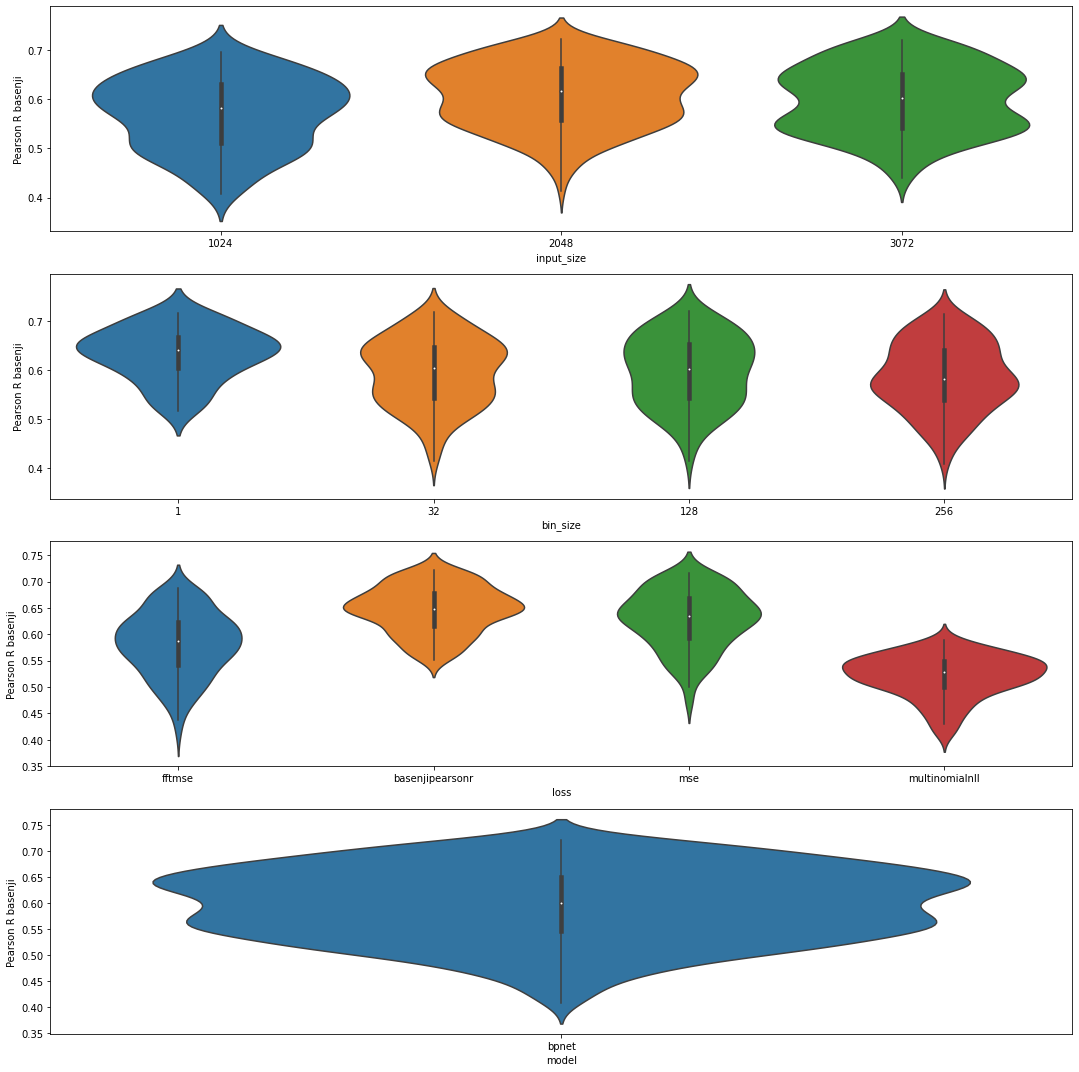

In [376]:
fig, axs = plt.subplots(4, figsize=[15,15])

for m, met in enumerate(['Pearson R basenji']):

    _=sns.violinplot(x='input_size', y=met, data=all_metrics, ax=axs[0])
    _=sns.violinplot(x='bin_size', y=met, data=all_metrics, ax=axs[1])
    _=sns.violinplot(x='loss', y=met, data=all_metrics, ax=axs[2])
    _=sns.violinplot(x='model', y=met, data=all_metrics, ax=axs[3])
#     axs[2,m].set_xticklabels(axs[2,m].get_xticklabels(), rotation=90)
# axs[2].set_xticks()
plt.tight_layout()

In [299]:
met_no_pr = all_metrics[all_metrics['loss']!='basenjipearsonr']

/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 81.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 82.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 81.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 82.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 81.7% of 

/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 93.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 66.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 97.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 94.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/shush/tf_2/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 75.5% of 

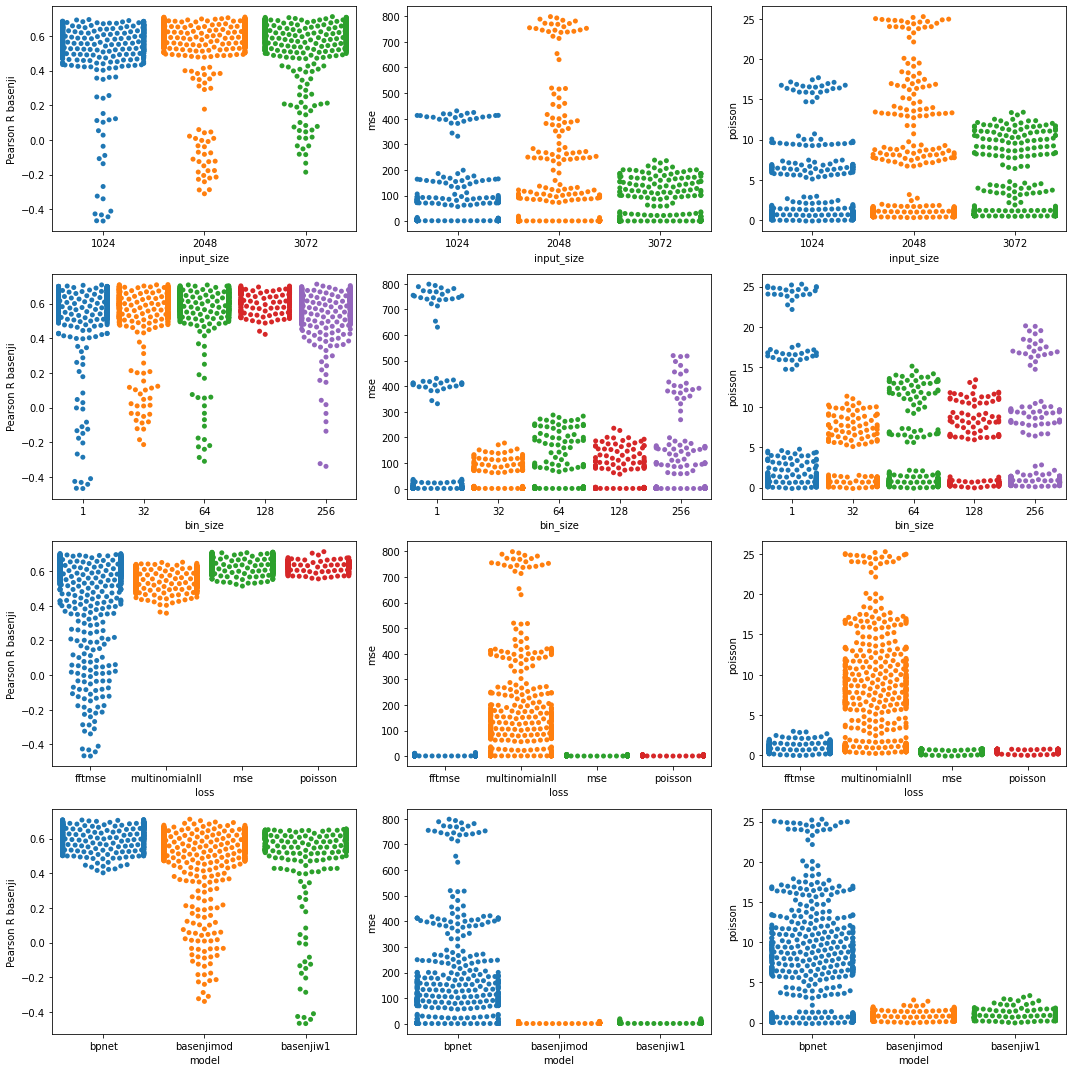

In [301]:
fig, axs = plt.subplots(4,3, figsize=[15,15])

for m, met in enumerate(['Pearson R basenji', 'mse', 'poisson']):

    _=sns.swarmplot(x='input_size', y=met, data=met_no_pr, ax=axs[0,m])
    _=sns.swarmplot(x='bin_size', y=met, data=met_no_pr, ax=axs[1,m])
    _=sns.swarmplot(x='loss', y=met, data=met_no_pr, ax=axs[2,m])
    _=sns.swarmplot(x='model', y=met, data=met_no_pr, ax=axs[3,m])
#     axs[2,m].set_xticklabels(axs[2,m].get_xticklabels(), rotation=90)
# axs[2].set_xticks()
plt.tight_layout()

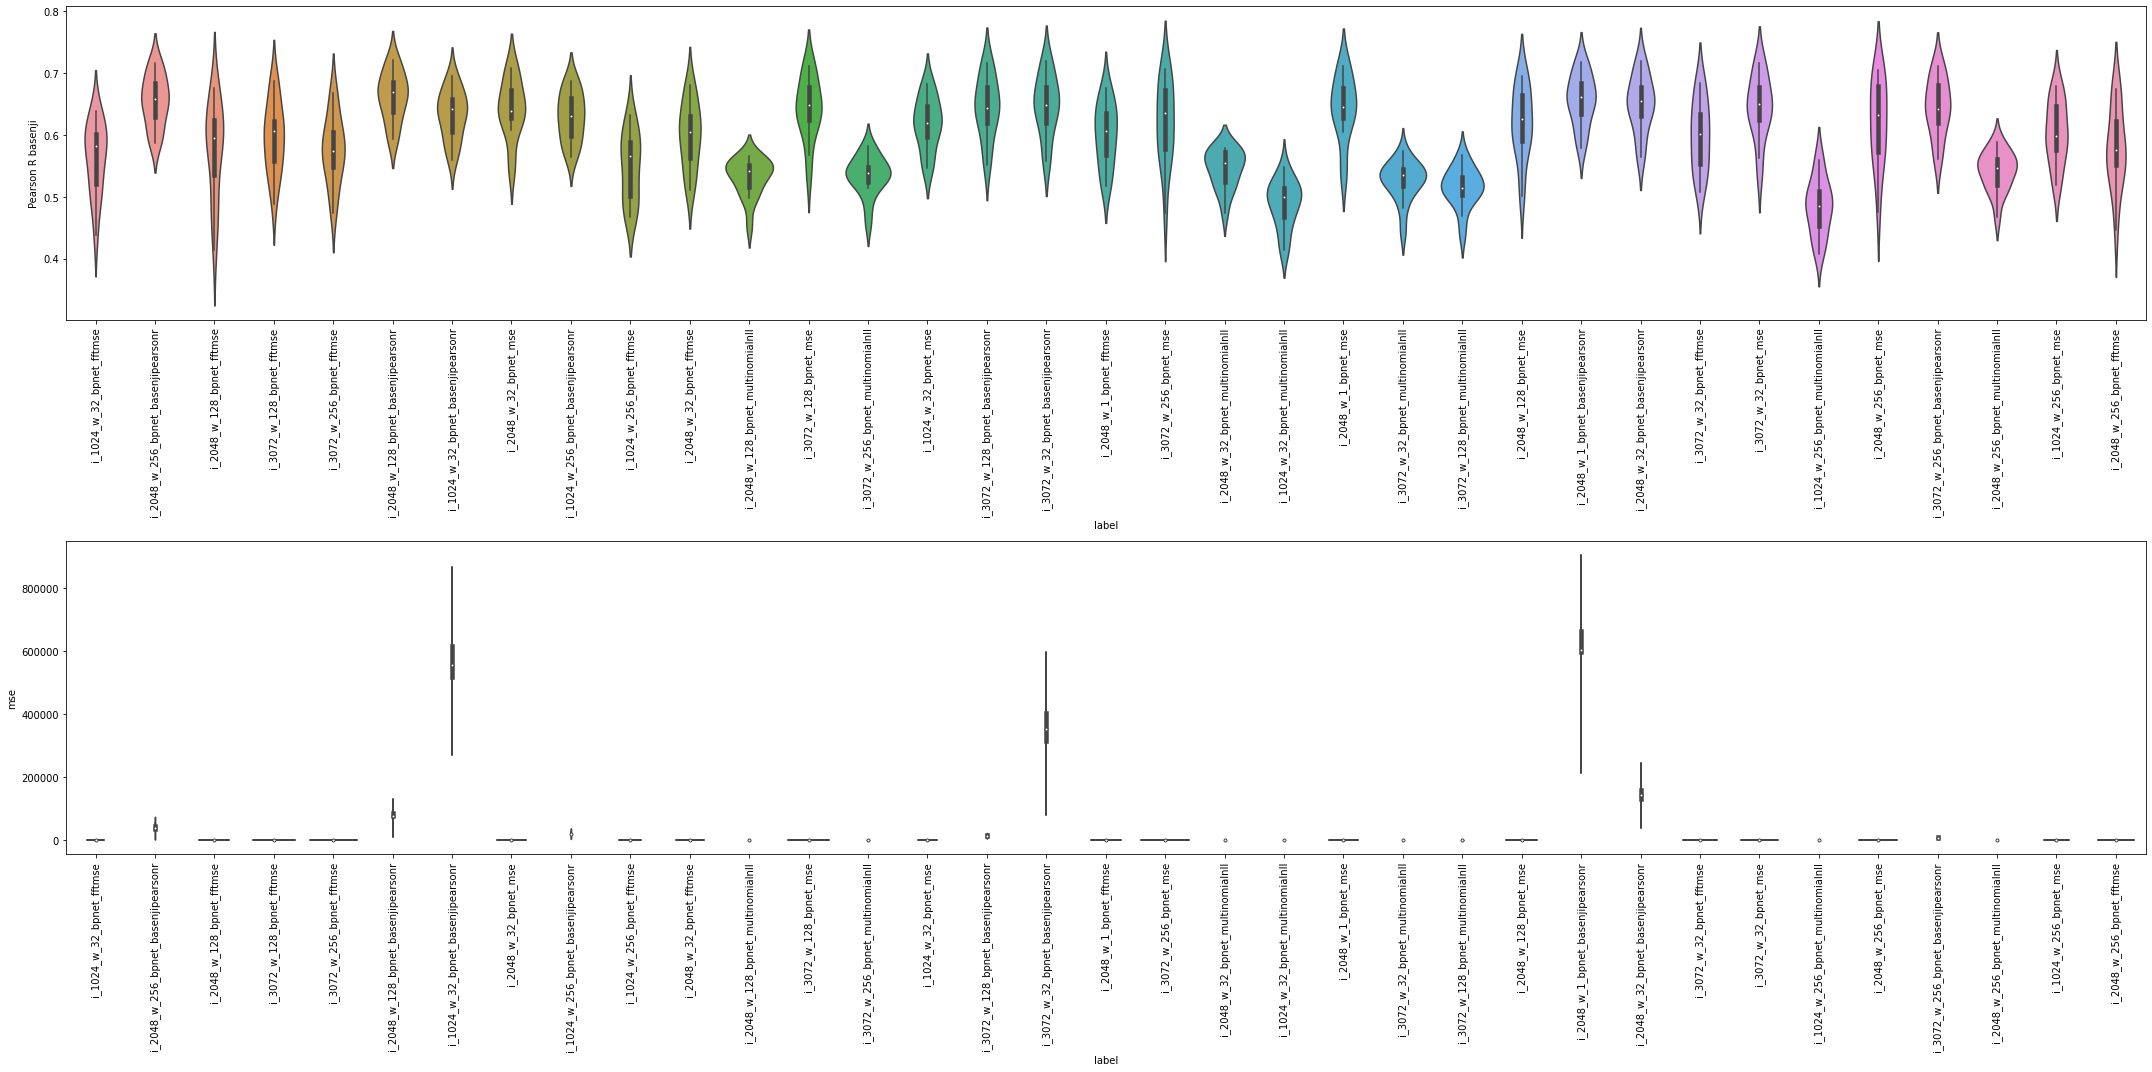

In [402]:
fig,axs = plt.subplots(2,1, figsize=[30,15])
_=sns.violinplot(x='label', y='Pearson R basenji', data=all_metrics, ax=axs[0])
# axs[0].set_xticks([], [])
_=axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
_=sns.violinplot(x='label', y='mse', data=all_metrics, ax=axs[1])
# axs[1].set_xticks([], [])
_=axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
# _=sns.violinplot(x='label', y='poisson', data=all_metrics, ax=axs[2])

# _=plt.xticks(rotation=90)
plt.tight_layout()

In [504]:
select_models = [os.path.join(grid_dir, f+'.h5') for f in ['pred_i_3072_w_32_bpnet_mse', 'pred_i_3072_w_128_bpnet_fftmse']]


In [506]:
select_models[1]

'datasets/ATAC_v2/grid5/pred_i_3072_w_128_bpnet_fftmse.h5'

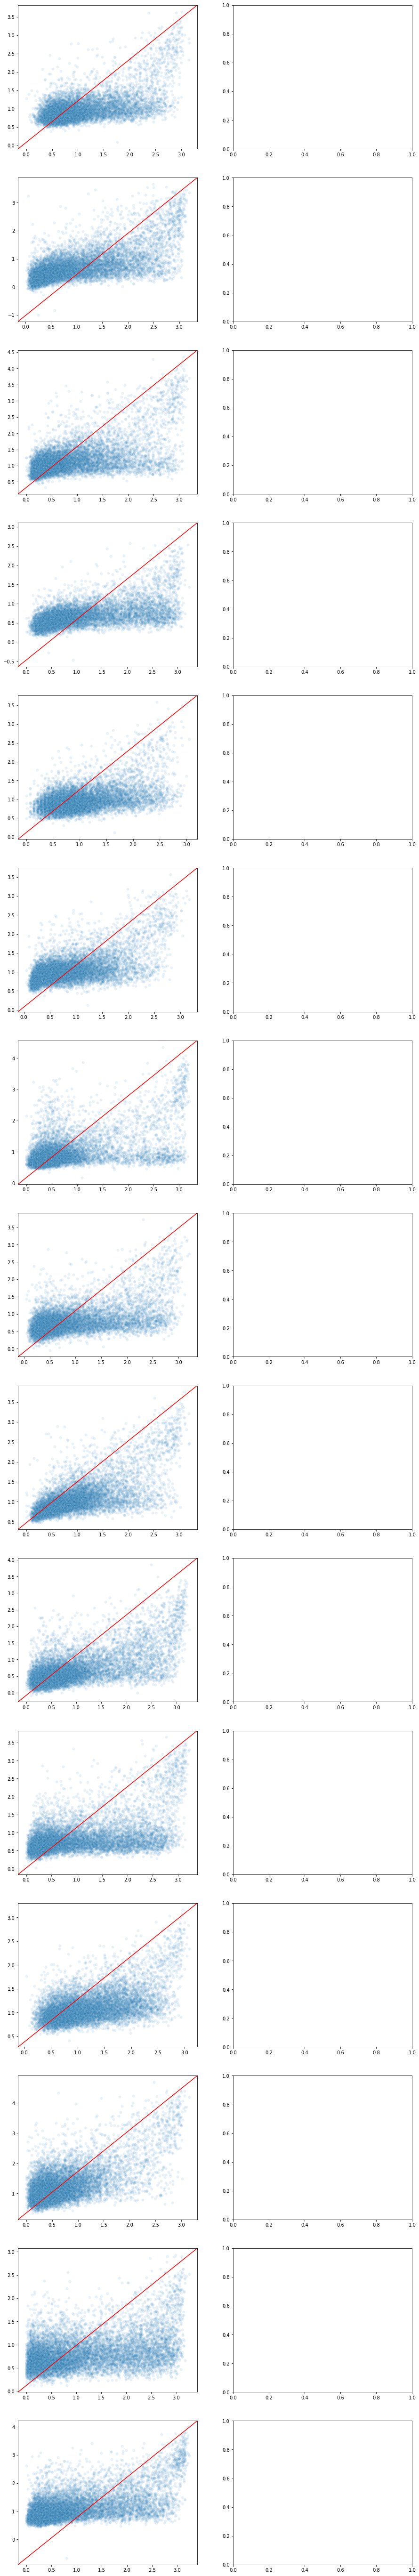

In [508]:
nplots = test_pred.shape[-1]
# nplots=3
fig, axs = plt.subplots(nplots, 2, figsize=[15,100])

for m, pred in enumerate([select_models[1]]):
    dataset = h5py.File(pred, 'r')
    test_pred = dataset['test_pred'][:]
    test_y = dataset['test_y'][:]
    for t in range(nplots):
        sns.scatterplot(x=test_y.mean(axis=1)[:,t], y=test_pred.mean(axis=1)[:,t], alpha=0.1, ax=axs[t,m])
        axs[t,m].plot([0,1],[0,1], transform=axs[t,m].transAxes, color='r')

In [510]:
pd.DataFrame({'true cov': test_y.mean(axis=1)[:,t], 'pred cov':test_pred.mean(axis=1)})

,true
0,0.095276
1,1.299919
2,1.658819
3,0.313018
4,0.700359
...,...
10681,1.088184
10682,2.643331
10683,0.850128
10684,0.430110


In [412]:
model = LinearRegression().fit(test_y.mean(axis=1)[:,t].reshape((-1, 1)), test_pred.mean(axis=1)[:,t])

In [426]:
x = np.arange(np.max(test_y.mean(axis=1)[:,t]))
y = model.predict(x.reshape((-1, 1)))

/home/shush/tf_2/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


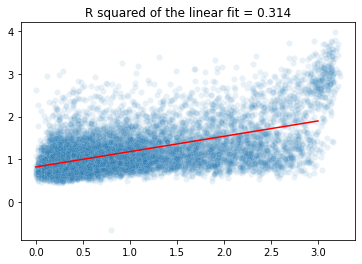

In [436]:
sns.scatterplot(x=test_y.mean(axis=1)[:,t], y=test_pred.mean(axis=1)[:,t], alpha=0.1)
sns.lineplot(x, y, color='r')
r_sq = model.score(test_y.mean(axis=1)[:,t].reshape((-1, 1)), test_pred.mean(axis=1)[:,t])
_=plt.title('R squared of the linear fit = {}'.format(np.around(r_sq,3)))

In [475]:
summary_table = all_metrics.groupby('label')[['Pearson R basenji', 'mse', 'poisson']].mean()

In [476]:
summary_table.to_csv(os.path.join(grid_dir, 'summary_{}_pearsonr.csv'.format(gridN)))

In [491]:
summary_table


,Pearson R basenji,mse,poisson
label,,,
i_1024_w_256_bpnet_basenjipearsonr,0.629448,19473.404570,87.984572
i_1024_w_256_bpnet_fftmse,0.547950,3.603676,0.681045
i_1024_w_256_bpnet_mse,0.603858,2.944989,0.495403
i_1024_w_256_bpnet_multinomialnll,0.484394,206.727222,11.559855
i_1024_w_32_bpnet_basenjipearsonr,0.632746,565956.193450,522.249197
i_1024_w_32_bpnet_fftmse,0.562979,4.606671,0.667066
i_1024_w_32_bpnet_mse,0.619002,3.772964,0.387937
i_1024_w_32_bpnet_multinomialnll,0.488540,129.466527,8.805426
i_2048_w_128_bpnet_basenjipearsonr,0.662047,78742.773088,160.118231


In [503]:
fig = go.Figure()

for column in summary_table.columns.to_list():
    fig.add_trace(
        go.Scatter(
            x = summary_table.index,
            y = summary_table[column],
            name = column,
            mode='markers'
            
        ))
    
fig.update_layout(
    updatemenus=[go.layout.Updatemenu(
        active=0,
        buttons=list(
            [dict(label = 'All',
                  method = 'update',
                  args = [{'visible': [True, True, True]},
                          {'title': 'All',
                           
                           'showlegend':True}]),
             dict(label = 'Pearson R basenji',
                  method = 'update',
                  
                  args = [{'visible': [True, False, False ]}, # the index of True aligns with the indices of plot traces
                          {'title': 'Pearson R',
                           'showlegend':True}]),
             dict(label = 'mse',
                  method = 'update',
                  
                  args = [{'visible': [False, True, False ]},
                          {'title': 'mse',
                           'showlegend':True}]),
             dict(label = 'poisson',
                  method = 'update',
                  
                  args = [{'visible': [False, False, True]},
                          {'title': 'poisson',
                           'showlegend':True}])
            ])
        )
    ])

fig.show()

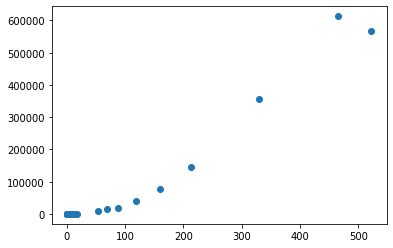

In [381]:
plt.scatter(summary_table['poisson'], summary_table['mse'])

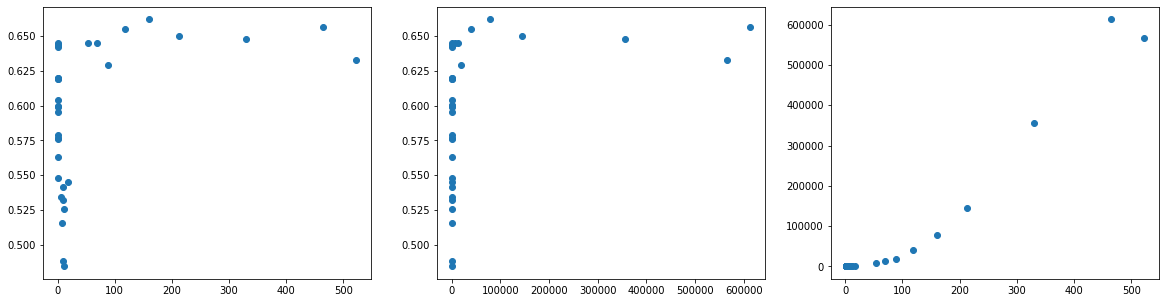

In [391]:
fig, axs = plt.subplots(1,3, figsize=[20,5])
axs[0].scatter(summary_table['poisson'], summary_table['Pearson R basenji'])
# axs[0].set_xlab('poisson')
axs[1].scatter(summary_table['mse'], summary_table['Pearson R basenji'])
axs[2].scatter(summary_table['poisson'], summary_table['mse'])

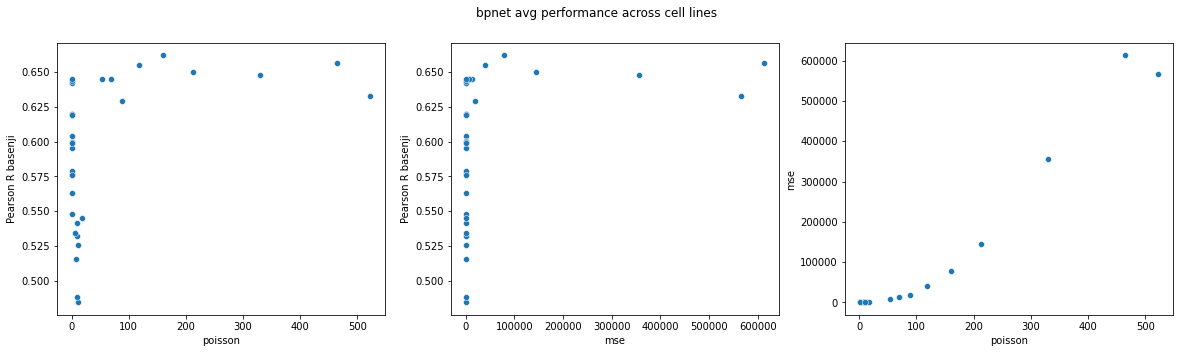

In [399]:
fig, axs = plt.subplots(1,3, figsize=[20,5])
sns.scatterplot(x='poisson', y='Pearson R basenji', data=summary_table, ax=axs[0])
# axs[0].set_xlab('poisson')
sns.scatterplot(x='mse', y='Pearson R basenji', data=summary_table, ax=axs[1])
_=sns.scatterplot(x='poisson', y='mse', data=summary_table, ax=axs[2])
_=fig.suptitle('bpnet avg performance across cell lines')